### Train a VLM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoVLM'):
    !git clone https://github.com/huggingface/nanoVLM.git
%cd nanoVLM/
!ls

Cloning into 'nanoVLM'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 145 (delta 84), reused 113 (delta 55), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 12.94 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content/nanoVLM
assets	data  generate.py  models  nanoVLM.ipynb  README.md  train.py


### Imports and Setup

In [2]:
# If you get an "Error" from pip's dependency resolver but the cell complets fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install datasets
!pip -q install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# nanoVLM Imports (please check out the implementations in detail, that's where all the interessting stuff is!)
from data.collators import VAQCollator, MMStarCollator
from data.datasets import MMStarDataset, VQADataset
from data.processors import get_image_processor, get_tokenizer
from models.vision_language_model import VisionLanguageModel
import models.utils as utils

# Libraries
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
%reload_ext autoreload
%autoreload 2

Using device: cuda


### Get the dataloaders

In [4]:
def get_dataloaders(train_cfg, vlm_cfg):
    # Create datasets
    image_processor = get_image_processor(vlm_cfg.vit_img_size)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

    # Load and combine all training datasets
    combined_train_data = []
    for dataset_name in train_cfg.train_dataset_name:
        train_ds = load_dataset(train_cfg.train_dataset_path, dataset_name)
        combined_train_data.append(train_ds['train'])
    train_ds = concatenate_datasets(combined_train_data)

    test_ds = load_dataset(train_cfg.test_dataset_path)

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    train_dataset = VQADataset(train_ds.select(range(total_samples)), tokenizer, image_processor)
    test_dataset = MMStarDataset(test_ds['val'], tokenizer, image_processor)

    # Create collators
    vqa_collator = VAQCollator(tokenizer, vlm_cfg.lm_max_length)
    mmstar_collator = MMStarCollator(tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=True,
        collate_fn=vqa_collator,
        num_workers=2,
        pin_memory=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=train_cfg.mmstar_batch_size,
        shuffle=False,
        collate_fn=mmstar_collator,
        pin_memory=True
        )

    return train_loader, test_loader

### Prepare the testing function

In [5]:
def test_mmstar(model, tokenizer, test_loader, device):
    # Go through MMStar and count how many answers we get right
    model.eval()
    total_examples = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in test_loader:
            image = batch['images'].to(device)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            correct_answer = tokenizer.batch_decode(labels, skip_special_tokens=True)

            gen = model.generate(input_ids, image, attention_mask)
            model_output = tokenizer.batch_decode(gen, skip_special_tokens=True)

            is_correct = utils.check_multiple_choice_with_regex(model_output, correct_answer)

            total_examples += len(is_correct)
            if is_correct:
                correct_predictions += sum(is_correct)

    accuracy = correct_predictions / total_examples if total_examples > 0 else 0

    return accuracy

### Prepare the training loop

In [6]:
def train(train_cfg, vlm_cfg):
    train_loader, test_loader = get_dataloaders(train_cfg, vlm_cfg)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer)

    # Initialize model
    if train_cfg.resume_from_vlm_checkpoint:
        model = VisionLanguageModel(vlm_cfg)
        model.load_checkpoint(vlm_cfg.vlm_checkpoint_path)
    elif vlm_cfg.vlm_load_backbone_weights:
        model = VisionLanguageModel.from_pretrained(vlm_cfg)
    else:
        model = VisionLanguageModel(vlm_cfg)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    param_groups = [{'params': model.MP.parameters(), 'lr': train_cfg.lr_mp},
                    {'params': list(model.decoder.parameters()) + list(model.vision_encoder.parameters()), 'lr': train_cfg.lr_backbones}]
    optimizer = optim.AdamW(param_groups)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    best_accuracy = 0
    global_step = 0
    for epoch in range(train_cfg.epochs):
        epoch_start_time = time.time()
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0

        for batch in tqdm(train_loader):
            batch_start_time = time.time()
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item() # Sum of attention mask gives number of tokens
            num_tokens += images.shape[0] * ((images.shape[2] / vlm_cfg.vit_patch_size) ** 2) / (vlm_cfg.mp_pixel_shuffle_factor ** 2) # Add image tokens = batch_size * (((img_size / patch_size) ** 2) / (pixel_shuffle_factor ** 2))
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 10 == 0:
                epoch_accuracy = 0
                if train_cfg.eval_in_epochs:
                    epoch_accuracy = test_mmstar(model, tokenizer, test_loader, device)
                    if epoch_accuracy > best_accuracy:
                      best_accuracy = epoch_accuracy
                      torch.save(getattr(model, '_orig_mod', model).state_dict(), vlm_cfg.vlm_checkpoint_path)
                    print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Tokens/s: {tokens_per_second:.2f}, Accuracy: {epoch_accuracy:.4f}")

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch+1}/{train_cfg.epochs}, Train Loss: {avg_train_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    # Summary Statistics
    if not train_cfg.eval_in_epochs:
      torch.save(getattr(model, '_orig_mod', model).state_dict(), vlm_cfg.vlm_checkpoint_path)

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    total_training_time = sum(epoch_times)
    total_samples_processed = len(train_loader.dataset) * train_cfg.epochs
    avg_time_per_sample = total_training_time / total_samples_processed
    print(f"Average time per epoch: {avg_epoch_time:.2f}s")
    print(f"Average time per sample: {avg_time_per_sample:.4f}s")

    plt.plot(batch_losses, label='Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Testing MMStar Accuracy:")
    accuracy = test_mmstar(model, tokenizer, test_loader, device)
    print(f"MMStar Accuracy: {accuracy:.4f}")

### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [7]:
@dataclass
class VLMConfig:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 224
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip-base-patch16-224'

    lm_hidden_dim: int = 576
    lm_inter_dim: int = 1536
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_vocab_size: int = 49152
    lm_n_heads: int = 9
    lm_n_kv_heads: int = 3
    lm_dropout: float = 0.0
    lm_n_blocks: int = 30
    lm_attn_scaling: float = 1.0
    lm_eos_token_id: int = 0
    lm_max_length: int = 128 - 49  # Deduct the image token lenght to achieve a 'nice number'
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embeding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/cosmo2-tokenizer'

    mp_pixel_shuffle_factor: int = 2

    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'nanoVLM.pth'


@dataclass
class TrainConfig:
    lr_mp: float = 1e-4
    lr_backbones: float = 5e-5
    compile: bool = False
    data_cutoff_idx: int = 1024 # Let's only use a small subset of the data at first, otherwise it takes very long to see anything :D
    batch_size: int = 12
    mmstar_batch_size: int = 12
    epochs: int = 5
    eval_in_epochs: bool = False # Deactivating this in colab, because it would evaluate 1500 samples of MMStar every time otherwise
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = 'HuggingFaceM4/the_cauldron'
    train_dataset_name: tuple[str, ...] = ("tqa", "vsr") #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",
    test_dataset_path: str = "Lin-Chen/MMStar"

### Lets run the training!

tokenizer_config.json:   0%|          | 0.00/3.91k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/489 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

(…)-00000-of-00001-c15be8aed9c93862.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1493 [00:00<?, ? examples/s]

(…)-00000-of-00001-b56e9224d46b0ed3.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2157 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

mmstar.parquet:   0%|          | 0.00/41.8M [00:00<?, ?B/s]

Generating val split:   0%|          | 0/1500 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Successfully loaded google/siglip-base-patch16-224 weights from safetensors. Model has 85,797,120 parameters.


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

Original vocabulary size from pretrained model: 49152
Using extended vocabulary size: 49152


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Tied token embedding and LM head weights
Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,515,008 parameters.
nanoVLM initialized with 222,081,600 parameters
Training summary: 1024 samples, 85 batches/epoch, batch size 12


100%|██████████| 85/85 [00:37<00:00,  2.27it/s]


Epoch 1/5, Train Loss: 0.4717 | Time: 37.47s | T/s: 2827.90


100%|██████████| 85/85 [00:35<00:00,  2.36it/s]


Epoch 2/5, Train Loss: 0.3578 | Time: 35.96s | T/s: 2947.17


100%|██████████| 85/85 [00:35<00:00,  2.37it/s]


Epoch 3/5, Train Loss: 0.3470 | Time: 35.92s | T/s: 2949.97


100%|██████████| 85/85 [00:35<00:00,  2.37it/s]


Epoch 4/5, Train Loss: 0.3450 | Time: 35.91s | T/s: 2951.51


100%|██████████| 85/85 [00:35<00:00,  2.37it/s]


Epoch 5/5, Train Loss: 0.3343 | Time: 35.92s | T/s: 2949.46
Average time per epoch: 36.24s
Average time per sample: 0.0354s


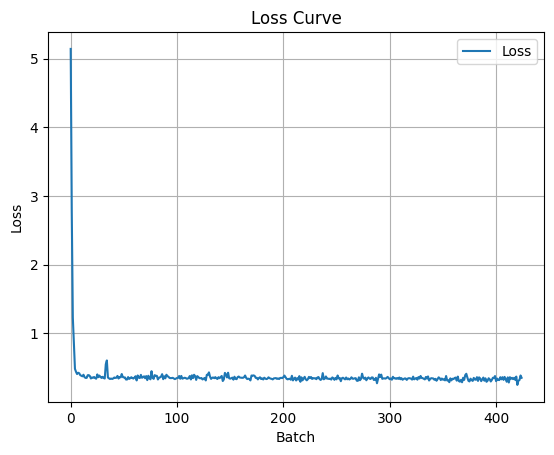

Testing MMStar Accuracy:
MMStar Accuracy: 0.0227


In [8]:
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()
train(train_cfg, vlm_cfg)

As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it